# A tutorial for identifying stochastic oscillations in single-cell live imaging time series using GPflow

## Introduction

This is a tutorial to accompany our paper: 

Phillips NE, Manning C, Papalopulu N & Rattray M (2017) Identifying stochastic oscillations in single cell live imaging time series using Gaussian processes. PLoS Comput Biol: 1–30 (https://doi.org/10.1371/journal.pcbi.1005479)

The aim of the method is to classify whether a single-cell gene expression time series is periodic. The original code used MATLAB, but this tutorial will show an alternative implementation using GPflow that provides a number of advantages. Here we will see a minimal implementation of the method, but it can easily be customised and extended for specific needs.

Contents:

1. Why GPflow?
2. The challenges of identifying oscillations in single-cell time series
3. Simulating the OU and OUosc models
4. An overview of the full analysis pipeline
5. An example analysis
6. Final thoughts

## Why GPflow?

GPflow (https://www.gpflow.org) is a package for implementing Gaussian process models using Python and TensorFlow. The cool thing about using GPflow is that it offers many functionalities that could help customise the method for specific biological questions. In this tutorial we will focus on a basic reimplementation of our published method, but here are just a few ways that GPflow could in principle be used to extend the model:

1. The method assumes that gene expression is either oscillatory or non-oscillatory for the entire duration of the time series. During development, however, stem cells may make dynamic transitions from oscillatory to non-oscillatory gene expression as they differentiate into more specialised cells. In the Discussion we suggested that it would be interesting to use a change-point model that could somehow account for this. A change-point kernel is implemented in GPflow (https://gpflow.github.io/GPflow/develop/notebooks/advanced/changepoints.html).

2. Similarly, the model assumes that the variance of the gene expression dynamics remains constant over time, but this assumption could be relaxed by using a heteroskedastic likelihood (https://gpflow.github.io/GPflow/develop/notebooks/advanced/heteroskedastic.html).

3. For our particular dataset, the time series were short enough such that we didn't need any tools to accelerate inference. When the inference becomes too time-consuming for longer time series, GPflow offers techniques such Stochastic Variational Gaussian Process (SVGP) that could help speed things up (https://gpflow.github.io/GPflow/develop/notebooks/advanced/gps_for_big_data.html).

4. We used maximum likelihood to fit our models, and so for each cell we have a single point estimate of parameter values. With GPflow it would be possible to use Hamiltonian Monte Carlo (HMC) to also have uncertainty on these parameters (https://gpflow.github.io/GPflow/develop/notebooks/advanced/mcmc.html), which could be used downstream for e.g. testing for differences in dynamics between two different cells. 

## The challenges of identififying oscillations in single-cell time series

As mentioned in the introduction of the paper, there are many interesting biological systems that exhibit oscillatory dynamics, such as circadian rhythms, the cell cycle, NF-KB oscillations in inflammation and p53 oscillations in response to DNA damage. 

We can now use live-cell imaging with fluorescent or bioluminescent markers to track gene expression in single cells, but for practical, technical and biological reasons, these time series are often short and noisy.

A common question is often posed: is the time series *really* oscillating?

Let's use a simple example to illustrate why this is a difficult question to answer.

Imagine that I give you the following sequence of coin flips: heads, tails, heads, tails (HTHT). And now imagine that I ask you whether you think the observed sequence was the outcome of an oscillatory process. On one hand, we do indeed observe a rhythmic pattern in the data. On the other hand, the sequence is pretty short and we don't have a lot of data to make a decision with. Perhaps this sequence was just the outcome of a series of completely random coin flips, where the periodicity just occurred by chance?

There's a further complication with biological systems. Unlike e.g. planetary motion, where we expect the period of oscillations to be extremely regular, in single cells the oscillations are often noisy with an irregular peak-to-peak period. One possible source of this stochasticity is the fact that intra-cellular oscillations are controlled by reactions involving a low number of interacting molecules. To reuse the analogy of coin-flipping, this irregularity in the period means that oscillatory gene expression in single cells is more like: HHTTTHHHTTHHTTTT.

Conceptually, the most important aspect of the method to understand is that for each cell we will propose two different models of the underlying dynamics: 1) a non-oscillatory model that generates noisy fluctuations with a given general timescale but without a specific period (the OU model), 2) an oscillatory model where the period of the oscillations are not necessarily perfect (the OUosc model).

The best way of gaining an intuition for the method is by first simulating the non-oscillatory OU and the oscillatory OUosc models.

## Setting up the environment

The right packages (and versions) are needed for this tutorial to run, and a conda environment is included for this purpose.

If you don't already have Anaconda, you can download it [here](https://www.anaconda.com/products/distribution).

We'll use the GPosc.yml file included in the Github folder to download the right package versions. Open a terminal and first change directory to where you've downloaded the .yml file. Then create a new environment in the terminal using (see guide for managing conda environments [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) ):

conda env create -f GPosc.yml

And activate it with:

conda activate GPosc

## Simulating the OU and OUosc models

The aperiodic OU model and the periodic (formally quasi-periodic) OUosc model are derived from a simplified model of intracellular dynamics, and the details of the two models are outlined in the original article. 

From a practical perspective, the OU model describes a noisy, aperiodic dynamical system controlled by two parameters: one parameter controls the rapidity of the fluctuations, and the second parameter controls the magnitude (or the variance) of the fluctuations.

Let's now simulate the model within GPflow. We first need to define the timescale (in units of hours), where a short timescale will lead to fast fluctuations. We then define the variance of the process, where a high variance will lead to large magnitude fluctuations.

I recommend playing with the timescale and variance parameters to get an intuition for how they affect the resulting dynamics.

Text(0, 0.5, 'Normalised gene expression')

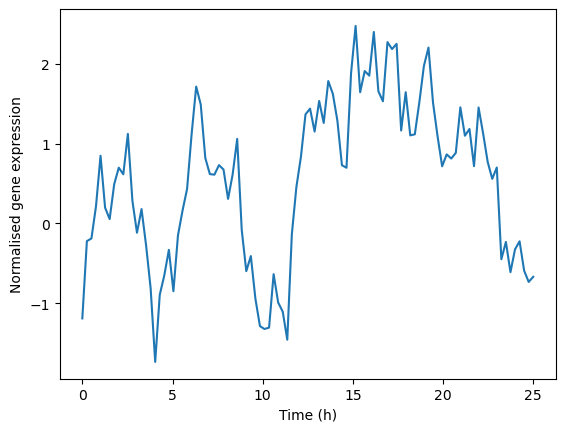

In [2]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from gpflow.utilities import print_summary, set_trainable, to_default_float
from scipy.signal import find_peaks

timescale = 2.0
variance = 1.0

X = np.linspace(0, 25, 100).reshape(-1, 1)
k_ou = gpflow.kernels.Matern12(lengthscales=timescale, variance=variance)

Y = np.random.multivariate_normal(np.zeros(len(X)), k_ou(X)).T

plt.plot(X, Y)
plt.xlabel("Time (h)")
plt.ylabel("Normalised gene expression")

The time series shows local peaks and troughs even though we generated it from a non-oscillatory process. This shows why heuristic methods based on finding peaks can't necessarily demonstrate that a time series is oscillating.

We can also simulate the periodic OUosc model. Like the OU model, the OUosc model also has a parameter that describes the rapidity of fluctuations and another that describes the variance. There is also a third variable that fixes the period the fluctuations. Once again, I recommend playing with these parameters.

Text(0, 0.5, 'Normalised gene expression')

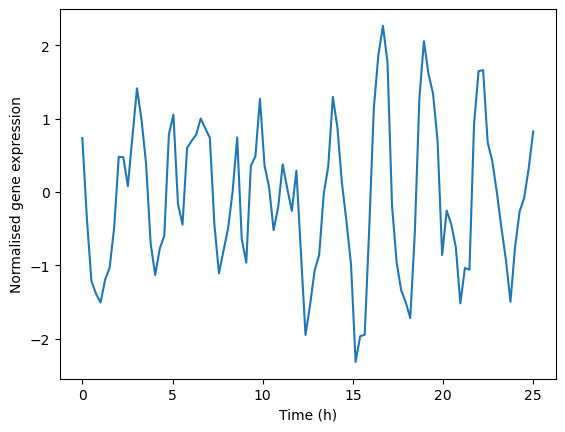

In [3]:
timescale = 2.0
variance = 1.0
period = 3.0

X = np.linspace(0, 25, 100).reshape(-1, 1)
k_ou_osc = gpflow.kernels.Matern12(
    lengthscales=timescale, variance=variance
) * gpflow.kernels.Cosine(lengthscales=period)

Y = np.random.multivariate_normal(np.zeros(len(X)), k_ou_osc(X)).T

plt.plot(X, Y)
plt.xlabel("Time (h)")
plt.ylabel("Normalised gene expression")

With the OUosc model we see noisy oscillations in the time series, such that the peak-to-peak period is irregular.

When we simulate the model, we provide the inputs to the model (i.e. the parameters) and we generate a stochastic time series as an output. In the analysis pipeline we effectively go in the other direction: we start with the time series (i.e. the data) and we find the parameters that "best describe" our data. We do this by maximising the log-likelihood of the data for a given set of parameters.

## An overview of the full analysis pipeline

In addition to the changes in gene expression that we see on fairly rapid timescales (e.g. 1-3 hours), we sometimes observe large, long timescale trends within the data. These trends may result from underlying biological processes or may simply result from microscopy artifacts of varying sources. The method involves a detrending step to remove these trends. The methods requires a characteristic timescale to remove trends, and we loosely recommend about 3X the expected period.

In addition to the long timescale trends, measuring gene expression using microscopy is not 100% accurate and there are errors associated with each measurement. In our analysis pipeline we model this experimental noise as Gaussian "white" noise, meaning that the measurement error is assumed to follow a normal distribution and that the errors are assumed to be independent at each time point. 

The Gaussian (i.e. normal) distribution describing the experimental error has a parameter that controls the variance. In the paper we estimated this experimental noise variance by creating four background regions that had the same area as a typical cell but were empty (i.e. they contained no cells). Using these four background regions, we then remove any long timescale trend while simultaneously estimating the experimental noise.

If background data is missing or otherwise unavailable, this error term can in principle be estimated from the data alongside other parameters of the model. One could, for example, add an experimental noise variance as a global parameter that's shared across cells, but in practice this complicates the analysis as it would no longer be possible to learn the parameters for each cell within a simple for loop (as is currently the case).

Here is a summary of the analysis pipeline:

Input: cells to be analysed, background cells (e.g. 4 regions).

1. Estimate experimental noise using background regions
2. Remove long timescale trend for each cell
3. Fit OU and OUosc model to each cell and calculate the log likelihood ratio (LLR) of the two models
4. Create a dataset of synthetic, non-oscillatory cells using the OU model. Calculate the LLR for each cell.
5. Using the LLRs of the observed cells and the synthetic, non-oscillatory cells, calculate a q-value for each observed cell.
6. Accept cells as oscillating if their associated q-value is lower than a cut-off (e.g. 0.05)

Output: a q-value for each cell that can be used to classify the cell as oscillatory.

## An example analysis

## Loading the data

We first load the data we wish to analyse. 

In [4]:
def load_data(file_name):
    df = pd.read_csv(file_name).fillna(0)
    data_cols = [col for col in df if col.startswith("Cell")]
    bckgd_cols = [col for col in df if col.startswith("Background")]
    time = df["Time (h)"].values[:, None]

    bckgd = df[bckgd_cols].values
    M = np.shape(bckgd)[1]

    bckgd_length = np.zeros(M, dtype=np.int32)

    for i in range(M):
        bckgd_curr = bckgd[:, i]
        bckgd_length[i] = np.max(np.nonzero(bckgd_curr))

    y_all = df[data_cols].values

    N = np.shape(y_all)[1]

    y_all = df[data_cols].values
    np.max(np.nonzero(y_all))

    y_length = np.zeros(N, dtype=np.int32)

    for i in range(N):
        y_curr = y_all[:, i]
        y_length[i] = np.max(np.nonzero(y_curr))

    return time, bckgd, bckgd_length, M, y_all, y_length, N


import os

os.chdir("../data/hes")
file_name = "Hes1_example.csv"  # add your file name here
time, bckgd, bckgd_length, M, y_all, y_length, N = load_data(file_name)

In [5]:
i = 1
print(bckgd[: bckgd_length[3], 3, None])

[[2124.393]
 [2119.678]
 [2128.286]
 [2122.643]
 [2108.036]
 [2123.214]
 [2112.036]
 [2119.857]
 [2118.75 ]
 [2103.5  ]
 [2112.822]
 [2117.393]
 [2103.822]
 [2106.822]
 [2108.072]
 [2106.643]
 [2101.107]
 [2107.572]
 [2100.178]
 [2105.714]
 [2097.75 ]
 [2092.607]
 [2095.393]
 [2100.214]
 [2094.322]
 [2103.643]
 [2092.072]
 [2097.107]
 [2106.286]
 [2092.178]
 [2093.607]
 [2090.286]
 [2093.   ]
 [2099.428]
 [2102.822]
 [2093.25 ]
 [2092.572]
 [2094.107]
 [2089.893]
 [2097.786]
 [2102.786]
 [2094.464]
 [2091.072]
 [2100.393]
 [2095.714]
 [2096.464]
 [2090.822]
 [2095.214]
 [2083.607]
 [2090.893]
 [2113.714]
 [2104.928]
 [2104.786]
 [2111.167]
 [2103.417]
 [2105.083]
 [2113.083]
 [2098.375]
 [2108.125]
 [2107.042]
 [2112.958]
 [2119.083]
 [2117.333]
 [2098.958]
 [2100.643]
 [2100.822]
 [2087.393]
 [2100.464]
 [2104.893]
 [2087.107]
 [2100.5  ]
 [2103.643]
 [2101.428]
 [2107.464]
 [2104.393]
 [2098.893]
 [2087.678]
 [2098.893]
 [2086.4  ]
 [2084.   ]
 [2102.6  ]
 [2104.68 ]
 [2094.68 ]
 [20

The "load_data" function accepts data with a specific format, which you can check using the provided example .csv file. There are three requirements:

- A column with the time of each measurement (units in hours). Column name: Time (h)
- Empty background regions that have the same area as a typical cell. The column name of each background region starts with: Background. There are four background regions in the example.
- Cells to be analysed, where the column name of each cell begins with: Cell

The load_data function returns seven outputs:
1. time - the time in hours
2. bckgd - the background regions
3. bckgd_length - this denotes the length of each background trace (which can be different)
4. M - the total number of background regions
5. y_all - the time series of the cells to be analysed
6. y_length - the length of each cell trace
7. N - the total number of cells to be analysed

## Estimating experimental noise

We then estimate the experimental noise. Using the background regions, we remove any long timescale trend while simultaneously estimating the experimental noise. The generated graphs show the estimated trend (black line) and 2X standard deviation (red lines).

(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=14.94501841492048>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=212.0446062169906>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=12.115685613473804>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=130.75992255803146>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=11.492106355155595>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=124.44537355309991>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=7.000007570851572>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=86.35540124376318>)
7.239964458255131


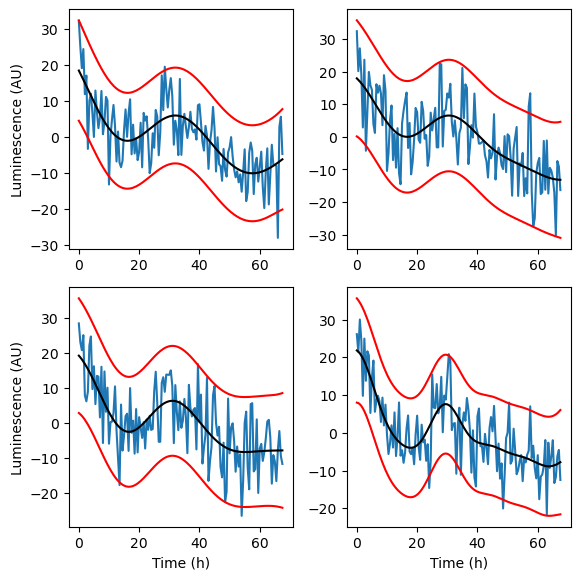

In [6]:
def optimised_background_model(X, Y):
    k = gpflow.kernels.SquaredExponential()
    m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
    m.kernel.lengthscales = gpflow.Parameter(
        to_default_float(7.1),
        transform=tfp.bijectors.Softplus(low=to_default_float(7.0)),
    )
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        m.training_loss, m.trainable_variables, options=dict(maxiter=100)
    )

    print(m.kernel.parameters)

    return m


std_vec = np.zeros(M)

fig = plt.figure(figsize=(15 / 2.54, 15 / 2.54))

for i in range(M):
    X = time[: bckgd_length[i]]
    Y = bckgd[: bckgd_length[i], i, None]
    Y = Y - np.mean(Y)

    m = optimised_background_model(X, Y)

    mean, var = m.predict_y(X)

    plt.subplot(2, 2, i + 1)
    plt.plot(X, Y)
    plt.plot(X, mean, "k")
    plt.plot(X, mean + 2 * var**0.5, "r")
    plt.plot(X, mean - 2 * var**0.5, "r")

    if i % 2 == 0:
        plt.ylabel("Luminescence (AU)")
    if i >= 2:
        plt.xlabel("Time (h)")

    std_vec[i] = m.likelihood.variance**0.5

plt.tight_layout()
std = np.mean(
    std_vec
)  # the estimated standard deviation of the experimental noise, averaged over all background traces

print(std)

## Fitting the OU and OUosc models to single-cell time series

Next, we will iterate over all cells to be analysed using a for loop. For each cell we will first remove any long term trend, fit the OU and OUosc models and calculate the log likelihood ratio (LLR) of the two models. We will also store the parameters of the fitted models, as we need the fitted parameters to simulate synthetic non-oscillatory cells from the OU model in the next step.

0
detrending
(92, 1)
OU/OUosc
[<tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449916034>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.2190644991565>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915839>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915518>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915923>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449917947>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915633>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.219064499156985>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449918623>, <tf.Tensor: shape=(), dtype=float64, numpy=-48.21906449915892>]
10
[<tf.Tensor: shape=(), dtype=float64, numpy=-44.37560586351367>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.375605863428206>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.3756058634318>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.37560586583197>, <tf.Tensor: shape=(), dtype=float64, numpy=-44.37560586342944>, <tf.T

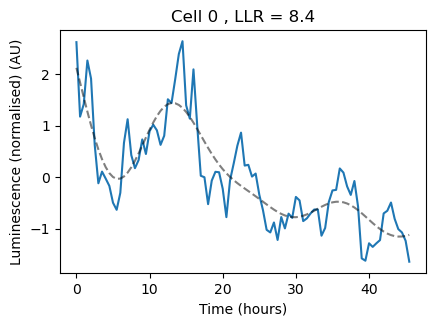

In [7]:
def detrend_cell(X, Y, detrend_lengthscale):
    k_trend = gpflow.kernels.SquaredExponential()
    m = gpflow.models.GPR(data=(X, Y), kernel=k_trend, mean_function=None)

    m.kernel.lengthscales = gpflow.Parameter(
        to_default_float(detrend_lengthscale + 0.1),
        transform=tfp.bijectors.Softplus(low=to_default_float(detrend_lengthscale)),
    )

    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(
        m.training_loss, m.trainable_variables, options=dict(maxiter=100)
    )

    mean, var = m.predict_f(X)

    Y_detrended = Y - mean
    Y_detrended = Y_detrended - np.mean(Y_detrended)

    return k_trend, mean, var, Y_detrended


def fit_models(X, Y, noise, K):
    OU_LL_list, OU_param_list, OUosc_LL_list, OUosc_param_list = [[] for _ in range(4)]

    for k in range(K):
        k_ou = gpflow.kernels.Matern12()

        m = gpflow.models.GPR(data=(X, Y), kernel=k_ou, mean_function=None)
        m.kernel.variance.assign(np.random.uniform(0.1, 2.0))
        m.kernel.lengthscales.assign(np.random.uniform(0.1, 2.0))
        m.likelihood.variance.assign(noise**2)
        gpflow.set_trainable(m.likelihood.variance, False)

        # gpflow.utilities.print_summary(m)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(
            m.training_loss, m.trainable_variables, options=dict(maxiter=100)
        )

        nlmlOU = m.log_posterior_density()

        OU_LL = nlmlOU
        OU_LL_list.append(OU_LL)
        OU_param_list.append(k_ou)

        k_ou_osc = gpflow.kernels.Matern12() * gpflow.kernels.Cosine()

        m = gpflow.models.GPR(data=(X, Y), kernel=k_ou_osc, mean_function=None)
        m.likelihood.variance.assign(noise**2)
        gpflow.set_trainable(m.likelihood.variance, False)
        gpflow.set_trainable(m.kernel.kernels[1].variance, False)
        m.kernel.kernels[0].variance.assign(np.random.uniform(0.1, 2.0))
        m.kernel.kernels[0].lengthscales.assign(np.random.uniform(0.1, 2.0))
        m.kernel.kernels[1].lengthscales.assign(np.random.uniform(0.1, 4.0))

        # print_summary(m)
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(
            m.training_loss, m.trainable_variables, options=dict(maxiter=100)
        )

        # print_summary(m)
        # print("---")

        nlmlOSC = m.log_posterior_density()  # opt_logs.fun

        OU_osc_LL = nlmlOSC
        OUosc_LL_list.append(OU_osc_LL)
        OUosc_param_list.append(k_ou_osc)

    print(OU_LL_list)
    print(len(OU_LL_list))
    print(OUosc_LL_list)
    print(len(OUosc_LL_list))

    LLR = 100 * 2 * (np.max(OUosc_LL_list) - np.max(OU_LL_list)) / len(Y)
    BIC_OUosc = -2 * np.max(OUosc_LL_list) + 3 * np.log(len(Y))
    BIC_OU = -2 * np.max(OU_LL_list) + 2 * np.log(len(Y))
    BICdiff = BIC_OU - BIC_OUosc

    print(np.max(OUosc_LL_list), np.max(OU_LL_list))
    print(BIC_OUosc, BIC_OU)
    print(BICdiff)

    k_ou = OU_param_list[np.argmax(OU_LL_list)]
    k_ou_osc = OUosc_param_list[np.argmax(OUosc_LL_list)]

    cov_ou_osc = OUosc_param_list[0](X).numpy()[0, :]
    peaks, _ = find_peaks(cov_ou_osc, height=0)

    if len(peaks) != 0:
        period = X[peaks[0]]
    else:
        period = 0

    return LLR, BICdiff, k_ou, k_ou_osc, period


def plot_model_fits(
    cell, x_curr, y_curr, mean_trend, noise, LLR, k_trend, k_ou, k_ou_osc, period
):
    fig = plt.figure(figsize=(12 / 2.54, 8 / 2.54))
    plt.plot(x_curr, y_curr)
    plt.plot(x_curr, mean_trend, "k--", alpha=0.5)
    plt.xlabel("Time (hours)")
    plt.ylabel("Luminescence (normalised) (AU)")
    plt.title("Cell " + str(cell) + " , LLR = " + f"{LLR:.1f}")


(
    noise_list,
    detrend_param_list,
    LLR_list,
    BICdiff_list,
    OU_param_list,
    OUosc_param_list,
    period_list,
) = [[] for _ in range(7)]

detrended_list = []
mean_list = []

for cell in range(N):
    print(cell)

    x_curr = time[: y_length[cell]]
    y_curr = y_all[: y_length[cell], cell, None]
    noise = std / np.std(y_curr)
    y_curr = (y_curr - np.mean(y_curr)) / np.std(y_curr)

    print("detrending")
    k_trend, mean_trend, var_trend, Y_detrended = detrend_cell(x_curr, y_curr, 7.0)
    print(mean_trend.shape)
    detrended_list.append(Y_detrended)
    mean_list.append(mean_trend)

    print("OU/OUosc")
    LLR, BICdiff, k_ou, k_ou_osc, period = fit_models(x_curr, Y_detrended, noise, 10)

    if cell == 0:
        plot_model_fits(
            cell,
            x_curr,
            y_curr,
            mean_trend,
            noise,
            LLR,
            k_trend,
            k_ou,
            k_ou_osc,
            period,
        )

    noise_list.append(noise)
    detrend_param_list.append(k_trend)
    LLR_list.append(LLR)
    BICdiff_list.append(BICdiff)
    OU_param_list.append(k_ou)
    OUosc_param_list.append(k_ou_osc)
    period_list.append(period)

In [9]:
print(noise_list)

[0.15274010714849082, 0.07359372242680665, 0.18020134277998504, 0.11851096976593475, 0.14537393010510466, 0.08990566229689037, 0.15720085161469757, 0.16190384328872245, 0.1635791353762151, 0.2543122300180026, 0.07180163366393756, 0.0737833346541194]


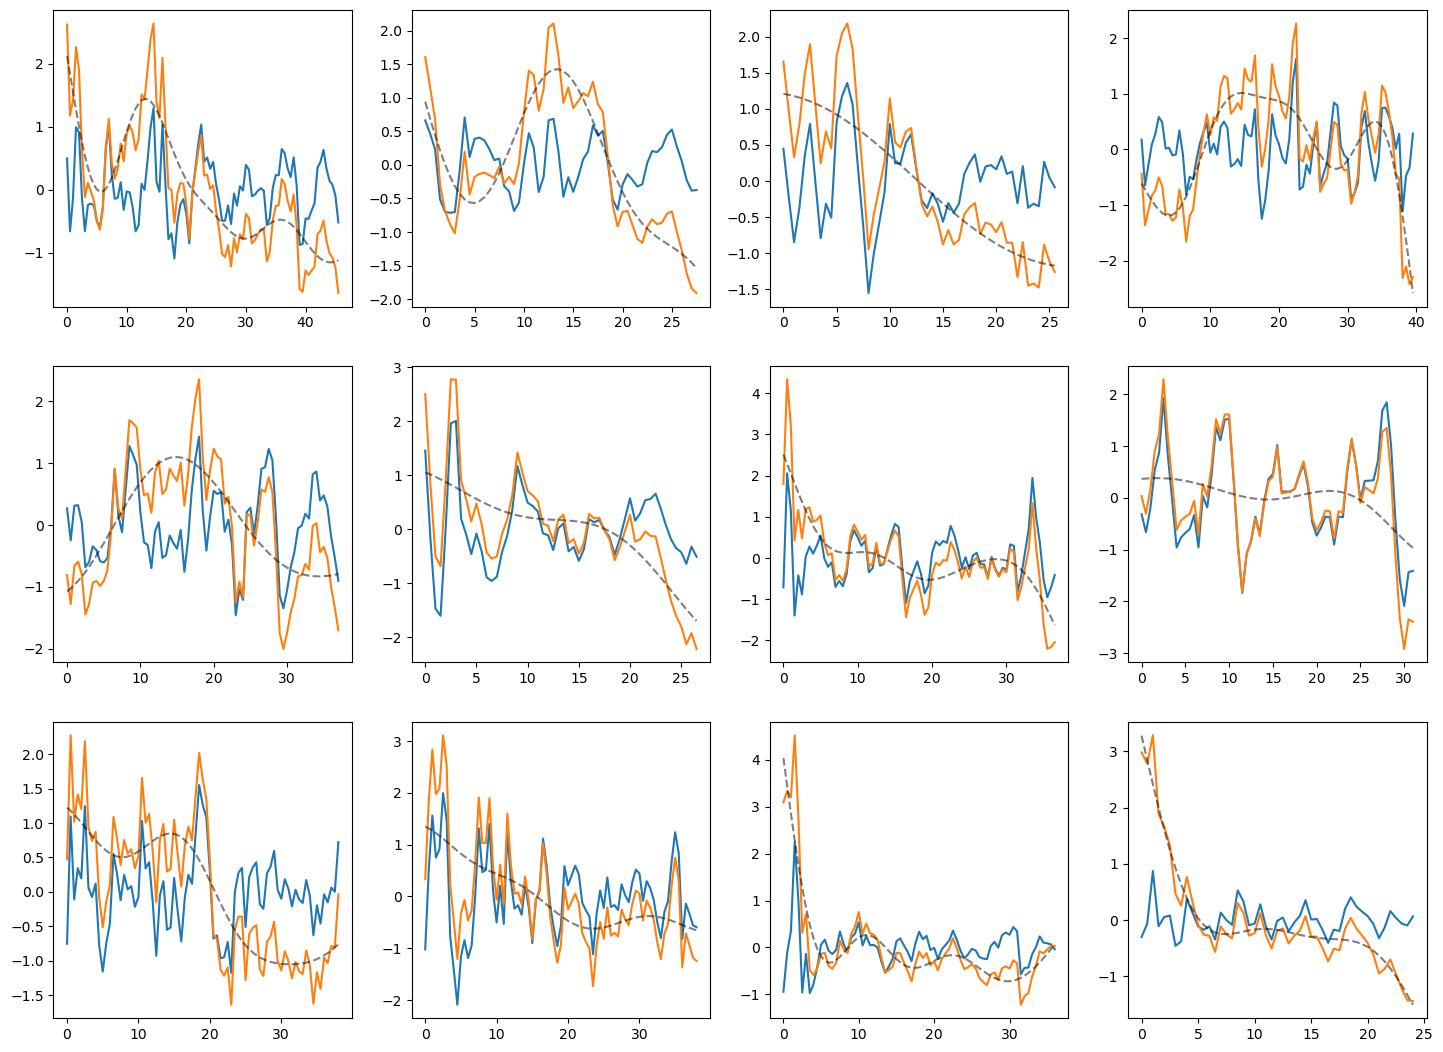

In [17]:
# plot all detrended traces with original data
fig = plt.figure(figsize=(15 / 2.54 * 3, 15 / 2.54 * 3))

for i in range(N):
    x_curr = time[: y_length[i]]
    y_curr = y_all[: y_length[i], i, None]
    mean_trend = mean_list[i]

    y_plot = (y_curr - np.mean(y_curr)) / np.std(y_curr)

    plt.subplot(4, 4, i + 1)
    plt.plot(x_curr, detrended_list[i])
    plt.plot(x_curr, y_plot)
    plt.plot(x_curr, mean_trend, "k--", alpha=0.5)

There are seven outputs of this section:

1. noise_list - each cell is normalised by dividing by the standard deviation. This list records the normalisation constant
2. detrend_param_list - records the parameters of the model used for detrending the cell
3. LLR_list - the log-likelihood ratio between OUosc and OU model for each cell
4. BICdiff_list - the difference in the Bayesian information criterion (BIC) between the models
5. OU_param_list - the fitted parameters of the OU model for each cell
6. OUosc_param_list - the fitted parameters of the OUosc model for each cell
7. period_list - the oscillatory period of the OUosc model. Note that even if a period is estimated, the cell may not pass the periodicity test performed later

## Rough estimation of number of oscillating cells using BIC

We now have a list of LLRs for the cells. In the full method we will calculate an LLR_list for synthetic, non-oscillating cells, but this can be quite time consuming.

A quicker method is to use the difference in the BIC between the two models [(BIC wiki page)](https://en.wikipedia.org/wiki/Bayesian_information_criterion). A cut-off on the BICdiff can then be used to accept the oscillatory model, and we can use a BICdiff>3 to consider the cell as oscillating ([Kass  & Raftery](https://doi.org/10.2307/2291091)).

Number of cells counted as oscillatory (BIC method): 10/12


Text(0.5, 1.0, 'LLRs of experimental cells')

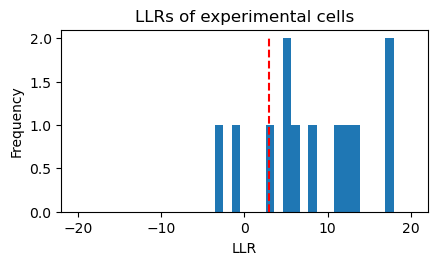

In [18]:
fig = plt.figure(figsize=(12 / 2.54, 6 / 2.54))

cutoff = 3
print(
    "Number of cells counted as oscillatory (BIC method): {0}/{1}".format(
        sum(np.array(BICdiff_list) > cutoff), len(BICdiff_list)
    )
)

plt.hist(BICdiff_list, bins=np.linspace(-20, 20, 40))
plt.plot([cutoff, cutoff], [0, 2], "r--")
plt.xlabel("LLR")
plt.ylabel("Frequency")
plt.title("LLRs of experimental cells")

## Full method for classifying cells as oscillatory based on synthetic OU cells (as in article)

For the full method we will use synthetic, non-oscillating cells to create a synthetic LLR_list. This will indicate the possible distribution of LLR scores that are generated by a non-periodic process.

We use the fitted parameters of the OU model for each cell to create a dataset of non-oscillating OU simulated cells with the same time length as the data. We then calculate the LLR of the OUosc vs OU model for each synthetic cell and store it in LLR_list_synth. This list of LLRs from the synthetic cells will be used to calculate the q-values during the final step of the pipeline.

In [ ]:
repeats = 10  # this controls the number of synthetic OU cells simulated for each observed cell

LLR_list_synth = []

for cell in range(N):
    print(cell)

    X = time[: y_length[cell]]
    noise = noise_list[cell]

    k_se = detrend_param_list[cell]
    k_ou = OU_param_list[cell]
    k_white = gpflow.kernels.White(variance=noise**2)

    k_synth = k_se + k_ou + k_white

    for repeat in range(repeats):
        y_synth = np.random.multivariate_normal(np.zeros(len(X)), k_synth(X)).reshape(
            -1, 1
        )
        k_trend, mean_trend, var_trend, Y_detrended = detrend_cell(X, y_synth, 7.0)
        LLR, BICdiff, k_ou, k_ou_osc, period = fit_models(X, Y_detrended, noise, 10)
        LLR_list_synth.append(LLR)

0
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.51994   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.932474  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.0233295 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧══════════

2024-11-24 15:40:52.431541: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 15:40:52.433959: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.111228  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.782892  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.0233295 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

2024-11-24 15:42:14.988224: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 15:42:14.989107: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-11-24 15:42:15.010397: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.14826    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.10724    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │ ()      │ float64 │ 0.00541604 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════

We can plot a side-by-side comparison of the LLR scores from the data and the synthetic cells. 

The list of LLR scores generated from the synthetic non-oscillatory cells shows that sometimes even simulated non-oscillatory cells will occasionally have quite a high LLR score, just by chance.

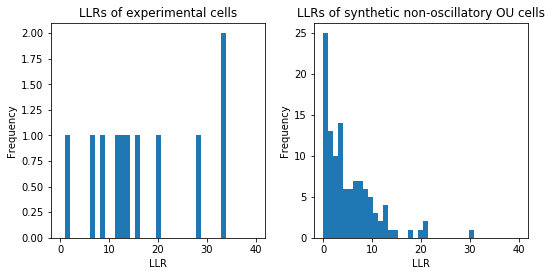

In [ ]:
fig = plt.figure(figsize=(20 / 2.54, 10 / 2.54))

plt.subplot(1, 2, 1)
plt.hist(LLR_list, bins=np.linspace(0, 40, 40))
plt.xlabel("LLR")
plt.ylabel("Frequency")
plt.title("LLRs of experimental cells")

plt.subplot(1, 2, 2)
plt.hist(LLR_list_synth, bins=np.linspace(0, 40, 40))
plt.xlabel("LLR")
plt.ylabel("Frequency")
plt.title("LLRs of synthetic non-oscillatory OU cells")

plt.tight_layout()

In the final step, we will use these two distributions to calculate a q-value for the presence of oscillations in each experimental cell.

Number of cells counted as oscillatory (full method): 10/12


Text(0, 0.5, 'Frequency')

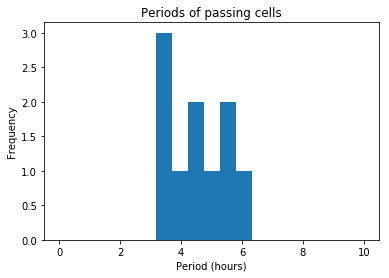

In [ ]:
LLR_array = np.array(LLR_list)
LLR_synth_array = np.array(LLR_list_synth)

# LLRs can be tiny and just negative - this just sets them to zero
LLR_array[LLR_array < 0] = 0
LLR_synth_array[LLR_synth_array < 0] = 0

LLR_combined = np.concatenate((LLR_array, LLR_synth_array), 0)

upper = np.max(LLR_combined)
lower1 = np.min(LLR_combined)
lower = upper - 0.9 * (upper - lower1)
grid = np.linspace(lower, upper, 20)

piest = np.zeros_like(grid)

for i, cutoff in enumerate(grid):
    num = sum(LLR_array < cutoff) / len(LLR_array)
    denom = sum(LLR_synth_array < cutoff) / len(LLR_synth_array)
    piest[i] = num / denom

xx = np.linspace(lower, upper, 100)
from scipy.interpolate import CubicSpline

cs = CubicSpline(grid, piest)
yy = cs(xx)

piGUESS1 = yy[0]

I = np.argsort(LLR_array)

LLR_array_sorted = LLR_array[I]

q1 = np.zeros_like(LLR_array_sorted)

for i, thresh in enumerate(LLR_array_sorted):
    q1[i] = (
        piGUESS1
        * (sum(LLR_synth_array >= thresh) / len(LLR_synth_array))
        / (sum(LLR_array_sorted >= thresh) / len(LLR_array_sorted))
    )

q_vals = q1[np.argsort(I)]
osc_filt = q_vals < 0.05

print(
    "Number of cells counted as oscillatory (full method): {0}/{1}".format(
        sum(osc_filt), len(osc_filt)
    )
)

period_array = np.array(period_list)
plt.hist(period_array[osc_filt], bins=np.linspace(0, 10, 20))
plt.title("Periods of passing cells")
plt.xlabel("Period (hours)")
plt.ylabel("Frequency")

The variable osc_filt is a boolean array that outputs "True" for each cell when its associated q-value is below the stated threshold (here we use 0.05). 

The final figure shows the period of each cell that passes the oscillatory test.